<a href="https://colab.research.google.com/github/ayushm-agrawal/pytorch-experiments/blob/master/CIFAR_10_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Imports


In [0]:
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torchsummary import summary
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt

####Check for GPU

In [0]:
print('PyTorch version:', torch.__version__)
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

PyTorch version: 1.4.0
CUDA is available!  Training on GPU ...


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Feb 12 17:27:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    31W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Set random seed for reproducability
torch.manual_seed(271828)
np.random.seed(271728)

####Load Data

In [0]:
# transform for the training data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])

# use the same transform for the validation data
test_transform = train_transform

# load datasets, downloading if needed
train_set = CIFAR10('./data/cifar10', train=True, download=True, 
                  transform=train_transform)
test_set = CIFAR10('./data/cifar10', train=False, download=True, 
                  transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


###Split train data to get Validation Set


In [0]:
train_len = len(train_set)
idxes = list(range(train_len))

#shuffle the indexes
np.random.shuffle(idxes)

split = int(np.floor(0.2*train_len))
train_idx, valid_idx = idxes[split: ], idxes[:split]

#Sampler gets the batches of data
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

###Dataloaders for Train, Test and Validation


In [0]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=20, sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=20, sampler=valid_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, num_workers=0)

####Image Classes

In [0]:
# 10 Classes in CIFAR-10 Dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

###Preview the data

In [0]:
print(train_set.data.shape)
print(test_set.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


###Visualizing the Data

In [0]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(np.transpose(img, (1,2,0))) # convert from tensor to image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

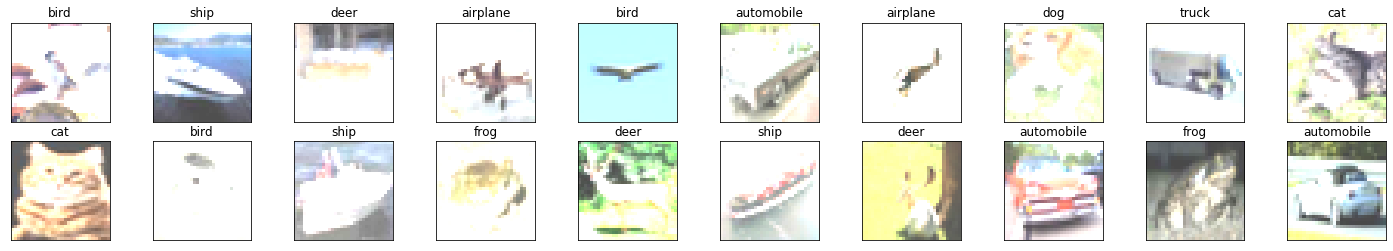

In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

figure = plt.figure(figsize=(25,4))
for i in np.arange(20):
  axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
  imshow(images[i])
  axis.set_title(classes[labels[i]])

##MODEL

In [0]:
class RandomNet(nn.Module):
  def __init__(self):
    super(RandomNet, self).__init__()

    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    #TODO: add more layers
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

    self.pool = nn.MaxPool2d(2,2)

    self.fc1 = nn.Linear(64*4*4, 500)
    self.output = nn.Linear(500, 10)

    self.dropout = nn.Dropout(0.25)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    x = x.view(-1, 64*4*4)

    x = self.dropout(x)

    x = F.relu(self.fc1(x))

    x = self.dropout(x)

    x = self.output(x)

    return x

model = RandomNet()

if train_on_gpu:
  model.cuda()

  
print(summary(model, (3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
           Dropout-7                 [-1, 1024]               0
            Linear-8                  [-1, 500]         512,500
           Dropout-9                  [-1, 500]               0
           Linear-10                   [-1, 10]           5,010
Total params: 541,094
Trainable params: 541,094
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.29
Params size (MB): 2.06
Estimated T

In [0]:
class SimpleNet(nn.Module):
  def __init__(self):
    super(SimpleNet, self).__init__()

    self.conv_3_64 = nn.Conv2d(3, 64, 3, padding=1)

    
    self.conv_64_128 = nn.Conv2d(64, 128, 3, padding=1)

    self.conv_128_128 = nn.Conv2d(128, 128, 3, padding=1)

    self.conv_128_256 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv_256_256 = nn.Conv2d(256, 256, 3, padding=1)
    self.conv_256_512 = nn.Conv2d(256, 512, 3, padding=1)
    self.conv_512_2048 = nn.Conv2d(512, 2048, 1, padding=1)
    self.conv_2048_256 = nn.Conv2d(2048, 256, 1, padding=1)
    self.pool = nn.MaxPool2d(2,2)

    self.dropout = nn.Dropout2d(p=0.1)
    self.drp = nn.Dropout(0.1)
    self.batchnorm1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True)
    self.batchnorm2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True)
    self.batchnorm3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True)
    self.batchnorm4 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.05, affine=True)
    self.batchnorm5 = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.05, affine=True)

    self.output = nn.Linear(256, 10)

  def forward(self, x):
    # conv input channels: 3 out channels: 64
    x = F.relu(self.batchnorm1(self.conv_3_64(x)))
    # conv input channels: 64 out channels: 128
    x = F.relu(self.batchnorm2(self.conv_64_128(x)))
    # conv input channels: 128 out channels: 128
    x = F.relu(self.batchnorm2(self.conv_128_128(x)))
    # conv input channels: 128 out channels: 128
    x = F.relu(self.batchnorm2(self.conv_128_128(x)))
    x = self.dropout(self.pool(x))

    
    # conv input channels: 128 out channels: 128
    x = F.relu(self.batchnorm2(self.conv_128_128(x)))
    # conv input channels: 128 out channels: 128
    x = F.relu(self.batchnorm2(self.conv_128_128(x)))
    
    # conv block 4
    x = F.relu(self.batchnorm3(self.conv_128_256(x)))
    x = self.dropout(self.pool(x))

    # conv block 5
    x = F.relu(self.batchnorm3(self.conv_256_256(x)))
    x = F.relu(self.batchnorm3(self.conv_256_256(x)))
    x = self.dropout(self.pool(x))

    # conv block 6
    x = F.relu(self.batchnorm4(self.conv_256_512(x)))
    x = self.dropout(self.pool(x))
    # conv block 7
    x = F.relu(self.batchnorm5(self.conv_512_2048(x)))
    x = F.relu(self.batchnorm3(self.conv_2048_256(x)))
    x = self.dropout(self.pool(x))

    # conv block 8
    x = F.relu(self.batchnorm3(self.conv_256_256(x)))
    
    x = F.max_pool2d(x, kernel_size=x.size()[2:])

    x = self.drp(x)

    # flatten
    x = x.view(x.size(0), -1)

    x = self.output(x)

    return x

model_SN = SimpleNet()
for m in model_SN.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))


if train_on_gpu:
  model_SN.cuda()

print(summary(model_SN, (3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,856
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 128, 32, 32]         147,584
       BatchNorm2d-6          [-1, 128, 32, 32]             256
            Conv2d-7          [-1, 128, 32, 32]         147,584
       BatchNorm2d-8          [-1, 128, 32, 32]             256
         MaxPool2d-9          [-1, 128, 16, 16]               0
        Dropout2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
           Conv2d-13          [-1, 128, 16, 16]         147,584
      BatchNorm2d-14          [-1, 128,

###Loss and Optimizer

In [0]:
learning_rate = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

###Training

In [0]:
epochs = 30

min_validation_loss = np.Inf

for epoch in range(1, epochs+1):

  train_loss = 0.0
  validation_loss = 0.0

  # training model loop
  model.train()
  for data, labels in train_loader:

    # if gpu is available then move the data on the gpu
    if train_on_gpu:
      data, labels = data.cuda(), labels.cuda()

    # clear the gradients
    optimizer.zero_grad()
    # make a forward pass
    output = model(data)
    # calculate the loss
    loss = criterion(output, labels)
    # do a backwards pass
    loss.backward()
    # perform a single optimization step
    optimizer.step()
    # update training loss
    train_loss += loss.item()*data.size(0)

  
  # validate the model
  model.eval()
  for data, labels in valid_loader:

    # if gpu is available then move the data on the gpu
    if train_on_gpu:
      data, labels = data.cuda(), labels.cuda()

    # forward pass
    output = model(data)

    # calculate the loss
    loss = criterion(output, labels)

    # update validation loss
    validation_loss += loss.item()*data.size(0)

  #average losses
  train_loss = train_loss/len(train_loader.dataset)
  validation_loss = validation_loss/len(valid_loader.dataset)

  print('Epoch: {} \tTraining Loss: {} \tValidation Loss: {}'.format(epoch, train_loss, validation_loss))

  #save model if validation loss has decreased
  if validation_loss <= min_validation_loss:
    print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ....'.format(
        min_validation_loss,
        validation_loss,
    ))

    torch.save(model.state_dict(), 'model_cifar-10.pt')
    min_validation_loss = validation_loss

Epoch: 1 	Training Loss: 1.3980184882164002 	Validation Loss: 0.3033551634311676
Validation loss decreased (inf --> 0.303355). Saving model ....
Epoch: 2 	Training Loss: 1.189871142888069 	Validation Loss: 0.28050438644886017
Validation loss decreased (0.303355 --> 0.280504). Saving model ....
Epoch: 3 	Training Loss: 1.1042888950109482 	Validation Loss: 0.2611419322967529
Validation loss decreased (0.280504 --> 0.261142). Saving model ....
Epoch: 4 	Training Loss: 1.0396819454193116 	Validation Loss: 0.2469881315469742
Validation loss decreased (0.261142 --> 0.246988). Saving model ....
Epoch: 5 	Training Loss: 0.9932472361564636 	Validation Loss: 0.24118753452301026
Validation loss decreased (0.246988 --> 0.241188). Saving model ....
Epoch: 6 	Training Loss: 0.9501970060110092 	Validation Loss: 0.2260369775056839
Validation loss decreased (0.241188 --> 0.226037). Saving model ....
Epoch: 7 	Training Loss: 0.9121669064044953 	Validation Loss: 0.21912966446876525
Validation loss decrea

### Training Simple Net

In [0]:
epochs = 540

min_validation_loss = np.Inf

for epoch in range(1, epochs+1):

  train_loss = 0.0
  validation_loss = 0.0

  # training model loop
  model_SN.train()
  for data, labels in train_loader:   

    # if gpu is available then move the data on the gpu
    if train_on_gpu:
      data, labels = data.cuda(), labels.cuda()

    # clear the gradients
    optimizer.zero_grad()
    # make a forward pass
    output = model_SN(data)
    # calculate the loss
    loss = criterion(output, labels)
    # do a backwards pass
    loss.backward()
    # perform a single optimization step
    optimizer.step()
    # update training loss
    train_loss += loss.item()*data.size(0)

  
  # validate the model
  model_SN.eval()
  for data, labels in valid_loader:

    # if gpu is available then move the data on the gpu
    if train_on_gpu:
      data, labels = data.cuda(), labels.cuda()

    # forward pass
    output = model_SN(data)

    # calculate the loss
    loss = criterion(output, labels)

    # update validation loss
    validation_loss += loss.item()*data.size(0)

  #average losses
  train_loss = train_loss/len(train_loader.dataset)
  validation_loss = validation_loss/len(valid_loader.dataset)

  print('Epoch: {} \tTraining Loss: {} \tValidation Loss: {}'.format(epoch, train_loss, validation_loss))

  #save model if validation loss has decreased
  if validation_loss <= min_validation_loss:
    print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ....'.format(
        min_validation_loss,
        validation_loss,
    ))

    torch.save(model_SN.state_dict(), 'model_cifar-10_SN.pt')
    min_validation_loss = validation_loss

Epoch: 1 	Training Loss: 2.168745173549652 	Validation Loss: 0.492030815410614
Validation loss decreased (inf --> 0.492031). Saving model ....
Epoch: 2 	Training Loss: 2.167065073108673 	Validation Loss: 0.49177867736816405
Validation loss decreased (0.492031 --> 0.491779). Saving model ....
Epoch: 3 	Training Loss: 2.1638881457328796 	Validation Loss: 0.49213178482055664
Epoch: 4 	Training Loss: 2.165991325569153 	Validation Loss: 0.4922624433517456
Epoch: 5 	Training Loss: 2.1646648490428926 	Validation Loss: 0.4919983467102051
Epoch: 6 	Training Loss: 2.1670043254852294 	Validation Loss: 0.4931499881744385
Epoch: 7 	Training Loss: 2.164241380596161 	Validation Loss: 0.49221920471191405
Epoch: 8 	Training Loss: 2.165521998786926 	Validation Loss: 0.491870276927948
Epoch: 9 	Training Loss: 2.166734870815277 	Validation Loss: 0.4912303605079651
Validation loss decreased (0.491779 --> 0.491230). Saving model ....
Epoch: 10 	Training Loss: 2.1686279544353484 	Validation Loss: 0.492042509

KeyboardInterrupt: ignored

###Testing Random Net



In [0]:
# load the model
model.load_state_dict(torch.load('model_cifar-10.pt'))

#test loss 
test_loss = 0.0
correct_class = list(0. for i in range(10))
total_class = list(0. for i in range(10))

model.eval()
for data, labels in test_loader:

  if train_on_gpu:
    data, labels = data.cuda(), labels.cuda()

  output = model(data)
  loss = criterion(output, labels)
  test_loss += loss.item()*data.size(0)

  _, pred = torch.max(output, 1)

  correct_tensor = pred.eq(labels.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

  #test accuracy for each object class
  for i in range(20):
    label = labels.data[i]
    correct_class[label] += correct[i].item()
    total_class[label] += 1
  
# avg test loss
test_loss = test_loss/len(test_loader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

# print test accuracy
for i in range(10):
  if total_class[i]>0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
          (classes[i], 100 * correct_class[i] / total_class[i],
          np.sum(correct_class[i]), np.sum(total_class[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nFinal Test  Accuracy: %2d%% (%2d/%2d)' % (
      100. * np.sum(correct_class) / np.sum(total_class),
      np.sum(correct_class), np.sum(total_class)))

### Testing Simple Net

In [0]:
# load the model
model_SN.load_state_dict(torch.load('model_cifar-10_SN.pt'))

#test loss 
test_loss = 0.0
correct_class = list(0. for i in range(10))
total_class = list(0. for i in range(10))

model_SN.eval()
for data, labels in test_loader:

  if train_on_gpu:
    data, labels = data.cuda(), labels.cuda()

  output = model_SN(data)
  loss = criterion(output, labels)
  test_loss += loss.item()*data.size(0)

  _, pred = torch.max(output, 1)

  correct_tensor = pred.eq(labels.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

  #test accuracy for each object class
  for i in range(20):
    label = labels.data[i]
    correct_class[label] += correct[i].item()
    total_class[label] += 1
  
# avg test loss
test_loss = test_loss/len(test_loader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

# print test accuracy
for i in range(10):
  if total_class[i]>0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
          (classes[i], 100 * correct_class[i] / total_class[i],
          np.sum(correct_class[i]), np.sum(total_class[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nFinal Test  Accuracy: %2d%% (%2d/%2d)' % (
      100. * np.sum(correct_class) / np.sum(total_class),
      np.sum(correct_class), np.sum(total_class)))